# Using XGBoost to infer links between telemetry

XGBoost stands for eXtreme Gradient BOOSTing.
It is an optimized parallel tree boosting method (GBDT Gradient Boosting Decision Tree). XGBoost creates an ensemble of decision trees, similar to random forest. XGBoost does it in a slightly different way, boosting; it is based on weak learners that have high bias (HB) and low variance (LV), boosting reduces inference errors by reducing the bias to get low bias (LB) and by the same occasion lower variance even more.
Alike Random forest which uses fully grown decision tree with low bias and high variance, before ensembling to mainly reduce the variance.

XGBoost -> Ensemble(HB, LV) = (LB, LV)
Random Forest -> Ensemble(LB, HV) = (LB, LV)

XGBoost model evolution is less random than Random Forest as it uses knowledge from not-fully-grown decision trees to build new ones. It is also faster as it does not grow trees completely. 

## Starting with importation of xgboost and useful libraries

In [1]:
import xgboost as xgb

# For the kung fu of data manipulation
import pandas as pd

# Useful function to split a data set for train/test sets
from sklearn.model_selection import train_test_split

# this following like is a called a "magic": it tells the notebook to display figures inline
%matplotlib inline

XGBoost parametrization is the tricky part. We could search what are the best parameters since we have data we can train on and test. But the following parameters will do fine for what we want; an estimation of dependencies, and not an exact prediction.

Your prediction errors can be reduced by changing these parameters but, usually, the importance/impact order of predictors (telemetry parameters used to predict one of them) does not change significantly.

More info on parameters here: https://xgboost.readthedocs.io/en/latest/parameter.html

In [2]:
params = {
    'learning_rate': 0.1,   # epsilon on slides
    'gamma': 0,             # minimum loss reduction to make a split 
    'max_depth': 10,        # maximum depth of the tree
    'n_estimators': 50,     # number of boosted trees to fit
    
    'base_score': 0.5,      # the initial prediction score of all instances, global bias.
    'colsample_bylevel': 1, # subsample ratio of columns for each split, in each level
    'colsample_bytree': 1,  # subsample ratio of columns when constructing each tree.
    'max_delta_step': 0,    # maximum delta step we allow each tree's weight estimation to be    
    'min_child_weight': 1,  # minimum sum of instance weight(hessian) needed in a child.
    'missing': None,        # how to represent missing value, defaults to np.nan
    'nthread': -1,          # number of parallel threads to run xgboost
    'objective': "reg:linear", # or 'binary:logistic'  or 
    'reg_alpha': 0,         # L1 regularization term on weights
    'reg_lambda': 1,        # L2 regularization term on weights
    'scale_pos_weight': 1,  # balance of positive and negative weights
    'seed': 0,              # randomness
    'verbosity': 1,         # formerly "silent", here 1 stands for only warnings
    'subsample': 1,         # subsample ratio of the training instance.
    
    # I do not really have a GPU on my laptop so I'll wait warming my hands with the CPU :)
    'predictor': "cpu_predictor", # or 'gpu_predictor'
    'tree_method': "auto"         # or "approx" or "(gpu_)hist" or "(gpu_)exact"
}

## Creating model object to be trained

    We use function *XGBClassifier* that returns a scikit-learn designed model.
    This permits to use pandas dataframe with it and standard scikit-learn interfaces .fit() .predict() .score()

In [3]:
# scikit-learn is needed for this form of model
model = xgb.XGBClassifier(**params)

## Getting data and splitting into train and test sets

    We are using the telemetry for Mars Express, available as Open Data (CC).
    It represents 33 telemetry parameters (Ampers) from its thermal subsystem, eache prefixed "NPWD*".

In [4]:
# Pandas can read compressed files directly. It detects the format, option: compression="infer"
# First column at index 0 is the data index
data = pd.read_csv("../data/mars-express-thermal-power--2014-01-01_2015-01-01.csv.gz", index_col=[0])

In [9]:
data.shape

(980322, 33)

In [6]:
# Transforming the index into human readable datetimestamp.
# unit="ms", means the datetimes are extracted from Unix timestamps that are in milliseconds
data.index = pd.to_datetime(data.index, unit='ms')

In [7]:
data.head(3)

,NPWD2372,NPWD2401,NPWD2402,NPWD2451,NPWD2471,NPWD2472,NPWD2481,NPWD2482,NPWD2491,NPWD2501,...,NPWD2792,NPWD2801,NPWD2802,NPWD2821,NPWD2851,NPWD2852,NPWD2871,NPWD2872,NPWD2881,NPWD2882
ut_ms,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:10.697,0.001457,0.001474,0.177440,0.005015,0.000714,0.006247,0.000554,0.001827,0.424989,0.005028,...,0.000996,0.001474,0.002123,0.005547,0.069760,0.000602,0.000598,0.000714,0.006457,0.003227
2014-01-01 00:00:42.708,0.001821,0.001474,0.177440,0.006019,0.000714,0.001001,0.000554,0.001827,0.430256,0.005028,...,0.000996,0.001474,0.002123,0.005547,0.647788,0.000602,0.000499,0.000714,0.007748,0.003227
2014-01-01 00:01:14.708,0.001821,0.001474,0.172173,0.006019,0.000714,0.001001,0.000554,0.001827,0.430256,0.005028,...,0.000996,0.001474,0.002389,0.005547,0.647788,0.000501,0.000499,0.000714,0.007748,0.003227


## Training the XGBoost model with Mars Express Telemetry to predict NPWD2551

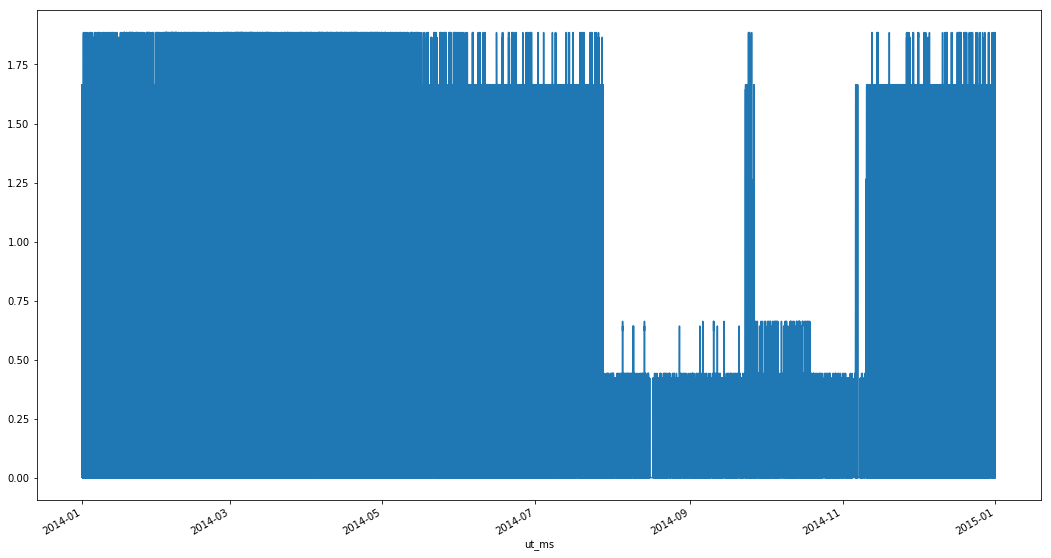

In [8]:
data.NPWD2551.plot(figsize=(18,10))

### Separating the target parameter we want to predict - here NPWD2551

In [10]:
# X represents all the features/predictors used to predict NPWD2551
X = data.drop("NPWD2551", axis=1)
Y = data.NPWD2551

### Splitting the dataset into a train set 
    Train set: used to fit the model
    Test set: not used for training, on which we can test the model
    
    Here we use one third of the data set (0.33) as test

In [11]:
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.33)

### Fitting the model

In [ ]:
model.fit(X_train, Y_train)

In [27]:
# It took about 21minutes, 50 trees and about 6GB of RAM to fit the model.
X_train.shape

(656815, 32)

### Using the trained model to make a prediction on the test set

In [29]:
from sklearn.metrics import mean_squared_error
y_test_prediction = model.predict(x_test)

In [30]:
err = mean_squared_error(y_test, y_test_prediction)
print(err)

0.6285218427025027


### Having a look at the other interesting outcome of the model: features importances

    Each of the 32 columns used to predict column NPWD2551 did server to branch in the different trees.
    Each of them were used at different branching intersection and how much they reduced the variance
    in the two resulting branches gives their importance. Importance of how much they affects the target variable,
    here: NPWD2551

In [33]:
# Sorting and displaying feature importances

# importances is a list of tuples: (NAMEofCOLUMN, THISCOLUMN_IMPORTANCE)
importances = list(zip(data.columns, model.feature_importances_))

# Sort in reverse order for most important first
importances.sort(key=lambda x: x[1], reverse=True)

for F,I in importances:
    print("{}: {}".format(F,I))

NPWD2821: 0.09328124672174454
NPWD2532: 0.06986314803361893
NPWD2692: 0.05984467640519142
NPWD2801: 0.05914093554019928
NPWD2451: 0.053266316652297974
NPWD2771: 0.05198029428720474
NPWD2552: 0.05093182995915413
NPWD2372: 0.046125322580337524
NPWD2561: 0.0410098135471344
NPWD2491: 0.03835560753941536
NPWD2742: 0.03720354661345482
NPWD2872: 0.028689008206129074
NPWD2721: 0.02656528539955616
NPWD2551: 0.02587047591805458
NPWD2722: 0.024025391787290573
NPWD2791: 0.02310374192893505
NPWD2481: 0.021001454442739487
NPWD2472: 0.02016732655465603
NPWD2471: 0.0185258612036705
NPWD2531: 0.018125765025615692
NPWD2401: 0.018056105822324753
NPWD2402: 0.0180203840136528
NPWD2482: 0.017016571015119553
NPWD2501: 0.016823668032884598
NPWD2851: 0.016634337604045868
NPWD2881: 0.015925239771604538
NPWD2792: 0.015648387372493744
NPWD2802: 0.015235788188874722
NPWD2852: 0.015189348720014095
NPWD2562: 0.015139336697757244
NPWD2871: 0.01464100368320942
NPWD2691: 0.01459277793765068


That's all for this notebook.

# What's next ?

    - Using context as input data and not only other telemetry. With context we can make real prediction
      with telemetry over telemetry we do dependence analysis mostly and nowcasting.
      We could also come up with an novel behaviour detection
    - Cycle each target to analyze dependencies between all available telemetry.
      Using the dependency graph as a preselection for building more efficient prediction models.
    - Manage a baysian graph where models of confidences are build with quality of model of predictions